In [398]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import os
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold
from scipy.cluster.vq import kmeans2, whiten
from sklearn.preprocessing import StandardScaler

from matplotlib import pyplot as plt
%matplotlib inline

In [147]:
def get_mean_cv_acc(estimator, X, y, n_splits=10, seed=17):
    cv = StratifiedKFold(n_splits=n_splits, random_state=seed)
    return cross_val_score(estimator, X, y, scoring='accuracy', cv=cv).mean()

In [73]:
def add_real_time(df):
    df['request_time'] = df['request_ts'].apply(datetime.fromtimestamp)
    df['trans_time'] = df['trans_ts'].apply(datetime.fromtimestamp)

In [74]:
def get_train_test_df(df):
    train_df = df[(data['label'] != '?') & (data['label'] != '-')].reset_index(drop=True)
    test_df = df[data['label'] == '?'].reset_index(drop=True)
    y_train = train_df['label'].values.astype(int)
    train_df.drop('label', axis=1, inplace=True)
    test_df.drop('label', axis=1, inplace=True)
    return train_df, y_train, test_df

In [265]:
data = pd.read_csv('data/transport_data.csv')
data.head()

,log,lat,request_ts,trans_ts,label
0,30.295780,59.932167,1511956827,1511956594,0
1,30.219528,59.954617,1511956827,1511956746,-
2,30.409101,59.931679,1511956827,1511956747,-
3,30.293602,59.938892,1511956827,1511956759,-
4,30.360102,59.931103,1511956827,1511956767,-


In [266]:
data.shape

(58665, 5)

In [267]:
train_data, y_train, test_data = get_train_test_df(data)
train_data.head()

,log,lat,request_ts,trans_ts
0,30.295780,59.932167,1511956827,1511956594
1,30.385973,59.944260,1511956827,1511956782
2,30.374880,59.938213,1511956827,1511956802
3,30.347544,59.932667,1511956827,1511956811
4,30.312321,59.937405,1511956827,1511956820


In [227]:
test_data.head()

,log,lat,request_ts,trans_ts
0,30.359190,59.931217,1511956827,1511956787
1,30.355488,59.931679,1511956827,1511956811
2,30.312258,59.937222,1511956918,1511956905
3,30.367332,59.931988,1511956918,1511956907
4,30.329239,59.934929,1511956978,1511956967


In [228]:
y_train[:10]

array([0, 0, 1, 0, 2, 0, 1, 0, 0, 0])

In [229]:
train_data.shape, y_train.shape, test_data.shape

((10000, 4), (10000,), (5000, 4))

In [268]:
pd.value_counts(y_train)

0    4423
1    3372
2    2205
dtype: int64

** Train with based features **

In [95]:
forest = RandomForestClassifier(n_estimators=100, random_state=17)
logit = LogisticRegression(random_state=17)
xgb_clf = XGBClassifier(n_estimators=100, random_state=17)
knn = KNeighborsClassifier(n_neighbors=99)
svc = SVC(random_state=17)

algorithms = [forest, logit, xgb_clf, knn, svc]

In [83]:
features = [['log', 'lat', 'request_ts', 'trans_ts'], ['log', 'lat', 'request_ts'], 
            ['log', 'lat', 'trans_ts'], ['log', 'lat']]

In [67]:
%%time
for columns in features:
    print(columns, get_mean_cv_acc(forest, train_data[columns], y_train))

['log', 'lat', 'request_ts', 'trans_ts'] 0.3066603967879417
['log', 'lat', 'request_ts'] 0.2993723712364431
['log', 'lat', 'trans_ts'] 0.30006937422685925
['log', 'lat'] 0.5085051999153796
CPU times: user 59.2 s, sys: 630 ms, total: 59.8 s
Wall time: 59.8 s


In [68]:
%%time
for columns in features:
    print(columns, get_mean_cv_acc(logit, train_data[columns], y_train))

['log', 'lat', 'request_ts', 'trans_ts'] 0.44230011916958023
['log', 'lat', 'request_ts'] 0.44230011916958023
['log', 'lat', 'trans_ts'] 0.44230011916958023
['log', 'lat'] 0.5010054886258479
CPU times: user 802 ms, sys: 75 µs, total: 802 ms
Wall time: 853 ms


In [84]:
%%time
for columns in features:
    print(columns, get_mean_cv_acc(xgb_clf, train_data[columns], y_train))

['log', 'lat', 'request_ts', 'trans_ts'] 0.31007009191140933
['log', 'lat', 'request_ts'] 0.3093698927100125
['log', 'lat', 'trans_ts'] 0.3093684943056201
['log', 'lat'] 0.5720024892330281
CPU times: user 27.9 s, sys: 123 ms, total: 28 s
Wall time: 28.1 s


In [85]:
%%time
for columns in features:
    print(columns, get_mean_cv_acc(knn, train_data[columns], y_train))

['log', 'lat', 'request_ts', 'trans_ts'] 0.18445345268578803
['log', 'lat', 'request_ts'] 0.18365335198568733
['log', 'lat', 'trans_ts'] 0.18465325288558823
['log', 'lat'] 0.5641015795387052
CPU times: user 2.65 s, sys: 56 µs, total: 2.65 s
Wall time: 2.73 s


In [86]:
%%time
for columns in features:
    print(columns, get_mean_cv_acc(svc, train_data[columns], y_train))

['log', 'lat', 'request_ts', 'trans_ts'] 0.42339460346885494
['log', 'lat', 'request_ts'] 0.32746710948447477
['log', 'lat', 'trans_ts'] 0.42309420266965175
['log', 'lat'] 0.488802178725532
CPU times: user 2min 43s, sys: 1.02 s, total: 2min 44s
Wall time: 2min 47s


In [269]:
add_real_time(data)
add_real_time(train_data)
add_real_time(test_data)

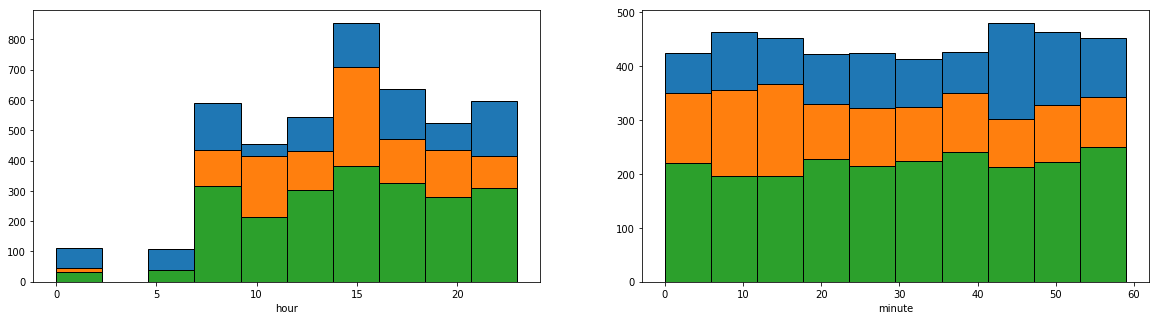

In [88]:
fig = plt.figure(figsize=(20, 5))

fig.add_subplot(1, 2, 1)
plt.hist(train_data[y_train == 0]['trans_time'].apply(lambda ts: ts.hour), edgecolor='black')
plt.hist(train_data[y_train == 1]['trans_time'].apply(lambda ts: ts.hour), edgecolor='black')
plt.hist(train_data[y_train == 2]['trans_time'].apply(lambda ts: ts.hour), edgecolor='black')
plt.xlabel('hour')

fig.add_subplot(1, 2, 2)
plt.hist(train_data[y_train == 0]['trans_time'].apply(lambda ts: ts.minute), edgecolor='black')
plt.hist(train_data[y_train == 1]['trans_time'].apply(lambda ts: ts.minute), edgecolor='black')
plt.hist(train_data[y_train == 2]['trans_time'].apply(lambda ts: ts.minute), edgecolor='black')
plt.xlabel('minute');

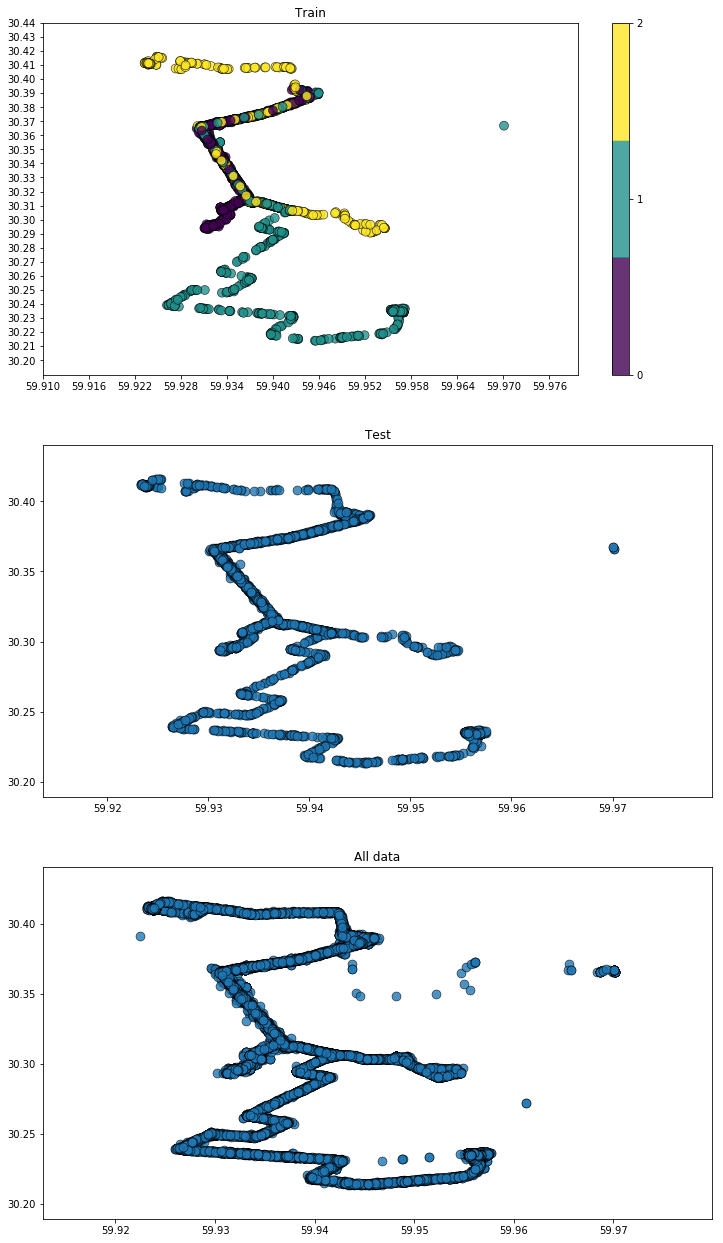

In [231]:
fig = plt.figure(figsize=(12, 22))

fig.add_subplot(3, 1, 1)
coordinates = train_data[['lat', 'log']].values
cmap = plt.get_cmap('viridis', 3)
plt.scatter(coordinates[:,0], coordinates[:,1], c=y_train, edgecolors='black', linewidth=0.6, alpha=0.8, s=80, 
            cmap=cmap)
plt.colorbar(ticks=[0, 1, 2])
plt.title('Train')
plt.yticks(np.arange(30.2, 30.45, 0.01))
plt.xticks(np.arange(59.91, 59.98, 0.006))


fig.add_subplot(3, 1, 2)
plt.scatter(test_data['lat'], test_data['log'], edgecolors='black', linewidth=0.6, alpha=0.8, s=80)
plt.title('Test')


fig.add_subplot(3, 1, 3)
plt.scatter(data['lat'], data['log'], edgecolors='black', linewidth=0.6, alpha=0.8, s=80)
plt.title('All data');

In [270]:
def add_xyz_features(df):
    df['x'] = df['lat'].apply(np.cos) * df['log'].apply(np.cos)
    df['y'] = df['lat'].apply(np.cos) * df['log'].apply(np.sin)
    df['z'] = df['lat'].apply(np.sin)

In [271]:
add_xyz_features(data)
add_xyz_features(train_data)
add_xyz_features(test_data)
train_data.head()

,log,lat,request_ts,trans_ts,request_time,trans_time,x,y,z
0,30.295780,59.932167,1511956827,1511956594,2017-11-29 15:00:27,2017-11-29 14:56:34,-0.422869,0.873954,-0.239554
1,30.385973,59.944260,1511956827,1511956782,2017-11-29 15:00:27,2017-11-29 14:59:42,-0.498340,0.829770,-0.251277
2,30.374880,59.938213,1511956827,1511956802,2017-11-29 15:00:27,2017-11-29 15:00:02,-0.489863,0.836542,-0.245420
3,30.347544,59.932667,1511956827,1511956811,2017-11-29 15:00:27,2017-11-29 15:00:11,-0.467463,0.850799,-0.240039
4,30.312321,59.937405,1511956827,1511956820,2017-11-29 15:00:27,2017-11-29 15:00:20,-0.436695,0.865708,-0.244636


In [96]:
%%time
for algo in algorithms:
    print(algo.__class__, get_mean_cv_acc(algo, train_data[['x', 'y', 'z']], y_train))

<class 'sklearn.ensemble.forest.RandomForestClassifier'> 0.5061012001012001
<class 'sklearn.linear_model.logistic.LogisticRegression'> 0.49720548343003435
<class 'xgboost.sklearn.XGBClassifier'> 0.5732011925281386
<class 'sklearn.neighbors.classification.KNeighborsClassifier'> 0.564502079439804
<class 'sklearn.svm.classes.SVC'> 0.48640197572772426
CPU times: user 49.4 s, sys: 460 ms, total: 49.9 s
Wall time: 50.4 s


In [272]:
data[data['log'] <= 30.29]['label'].value_counts()

-    12444
?      896
1      433
Name: label, dtype: int64

In [273]:
data[data['log'] >= 30.39263]['label'].value_counts()

-    4747
?     295
2     179
Name: label, dtype: int64

In [274]:
def add_lat_log_features(df):
    df['log_le_30.29'] = df['log'].apply(lambda log: log <= 30.29).astype(int)
    df['log_ge_30.39263'] = df['log'].apply(lambda log: log >= 30.39263).astype(int)    

In [141]:
add_lat_log_features(train_data)
train_data.head()

,log,lat,request_ts,trans_ts,request_time,trans_time,x,y,z,log_le_30.29,log_ge_30.39263
0,30.295780,59.932167,1511956827,1511956594,2017-11-29 15:00:27,2017-11-29 14:56:34,-0.422869,0.873954,-0.239554,0,0
1,30.385973,59.944260,1511956827,1511956782,2017-11-29 15:00:27,2017-11-29 14:59:42,-0.498340,0.829770,-0.251277,0,0
2,30.374880,59.938213,1511956827,1511956802,2017-11-29 15:00:27,2017-11-29 15:00:02,-0.489863,0.836542,-0.245420,0,0
3,30.347544,59.932667,1511956827,1511956811,2017-11-29 15:00:27,2017-11-29 15:00:11,-0.467463,0.850799,-0.240039,0,0
4,30.312321,59.937405,1511956827,1511956820,2017-11-29 15:00:27,2017-11-29 15:00:20,-0.436695,0.865708,-0.244636,0,0


In [148]:
%%time
for algo in algorithms:
    print(algo.__class__, get_mean_cv_acc(algo, train_data[['log', 'lat', 'log_le_30.29', 'log_ge_30.39263']], 
                                          y_train))

<class 'sklearn.ensemble.forest.RandomForestClassifier'> 0.5069051973159758
<class 'sklearn.linear_model.logistic.LogisticRegression'> 0.5034992009009974
<class 'xgboost.sklearn.XGBClassifier'> 0.5720024892330281
<class 'sklearn.neighbors.classification.KNeighborsClassifier'> 0.5650021795399042
<class 'sklearn.svm.classes.SVC'> 0.5034992009009974
CPU times: user 45.8 s, sys: 280 ms, total: 46 s
Wall time: 46 s


In [275]:
data.loc[data[(data['label'] == '-') & (data['log'] <= 30.29)].index, 'label'] = '1'

In [276]:
train_data, y_train, test_data = get_train_test_df(data)
train_data.head()

,log,lat,request_ts,trans_ts,request_time,trans_time,x,y,z
0,30.295780,59.932167,1511956827,1511956594,2017-11-29 15:00:27,2017-11-29 14:56:34,-0.422869,0.873954,-0.239554
1,30.219528,59.954617,1511956827,1511956746,2017-11-29 15:00:27,2017-11-29 14:59:06,-0.353008,0.898395,-0.261288
2,30.385973,59.944260,1511956827,1511956782,2017-11-29 15:00:27,2017-11-29 14:59:42,-0.498340,0.829770,-0.251277
3,30.236233,59.955753,1511956827,1511956783,2017-11-29 15:00:27,2017-11-29 14:59:43,-0.367852,0.892098,-0.262385
4,30.374880,59.938213,1511956827,1511956802,2017-11-29 15:00:27,2017-11-29 15:00:02,-0.489863,0.836542,-0.245420


In [277]:
train_data.shape, y_train.shape, test_data.shape

((22444, 9), (22444,), (5000, 9))

In [174]:
%%time
for algo in algorithms:
    print(algo.__class__, get_mean_cv_acc(algo, train_data[['log', 'lat']], y_train))

<class 'sklearn.ensemble.forest.RandomForestClassifier'> 0.7793174342841145
<class 'sklearn.linear_model.logistic.LogisticRegression'> 0.7508925456142217
<class 'xgboost.sklearn.XGBClassifier'> 0.8090797984511446
<class 'sklearn.neighbors.classification.KNeighborsClassifier'> 0.8061838989764603
<class 'sklearn.svm.classes.SVC'> 0.7637232800422253
CPU times: user 1min 36s, sys: 1.19 s, total: 1min 37s
Wall time: 1min 37s


In [278]:
data.loc[data[(data['label'] == '-') & (data['log'] >= 30.39263)].index, 'label'] = '2'

In [279]:
train_data, y_train, test_data = get_train_test_df(data)
train_data.head()

,log,lat,request_ts,trans_ts,request_time,trans_time,x,y,z
0,30.295780,59.932167,1511956827,1511956594,2017-11-29 15:00:27,2017-11-29 14:56:34,-0.422869,0.873954,-0.239554
1,30.219528,59.954617,1511956827,1511956746,2017-11-29 15:00:27,2017-11-29 14:59:06,-0.353008,0.898395,-0.261288
2,30.409101,59.931679,1511956827,1511956747,2017-11-29 15:00:27,2017-11-29 14:59:07,-0.519045,0.820630,-0.239080
3,30.385973,59.944260,1511956827,1511956782,2017-11-29 15:00:27,2017-11-29 14:59:42,-0.498340,0.829770,-0.251277
4,30.236233,59.955753,1511956827,1511956783,2017-11-29 15:00:27,2017-11-29 14:59:43,-0.367852,0.892098,-0.262385


In [280]:
train_data.shape, y_train.shape, test_data.shape

((27191, 9), (27191,), (5000, 9))

In [281]:
pd.value_counts(y_train)

1    15816
2     6952
0     4423
dtype: int64

In [185]:
%%time
for algo in algorithms:
    print(algo.__class__, get_mean_cv_acc(algo, train_data[['log', 'lat']], y_train))

<class 'sklearn.ensemble.forest.RandomForestClassifier'> 0.8190583927820656
<class 'sklearn.linear_model.logistic.LogisticRegression'> 0.7491082894048473
<class 'xgboost.sklearn.XGBClassifier'> 0.8428157793888935
<class 'sklearn.neighbors.classification.KNeighborsClassifier'> 0.8398738181297004
<class 'sklearn.svm.classes.SVC'> 0.7934248028892144
CPU times: user 2min 25s, sys: 1.72 s, total: 2min 26s
Wall time: 2min 27s


In [188]:
xgb_clf.fit(train_data[['log', 'lat']], y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=17,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

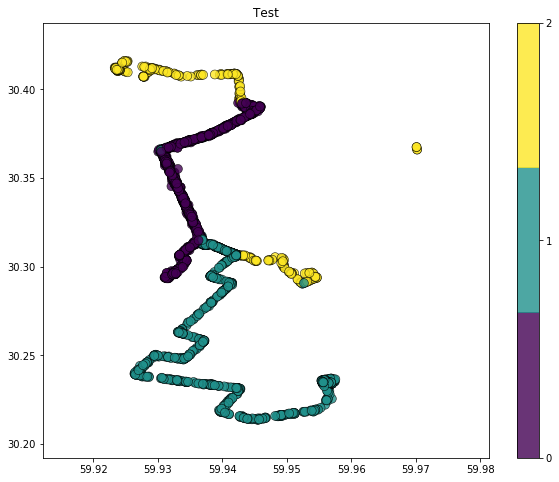

In [243]:
plt.figure(figsize=(10, 8))
y_pred = xgb_clf.predict(test_data[['log', 'lat']])
cmap = plt.get_cmap('viridis', 3)
plt.scatter(test_data['lat'], test_data['log'], edgecolors='black', c=y_pred, linewidth=0.6, alpha=0.8, s=80,
            cmap=cmap)
plt.colorbar(ticks=[0, 1, 2])             
plt.title('Test');

In [282]:
def add_numeric_time_features(df):
    df['hour'] = df['trans_time'].apply(lambda ts: ts.hour)
    df['minute'] = df['trans_time'].apply(lambda ts: ts.minute)
    df['second'] = df['trans_time'].apply(lambda ts: ts.second)
    df['HHMMSS'] = df['trans_time'].apply(lambda ts: (ts.hour * 100 + ts.minute) * 100 + ts.second)
    df['HHMM'] = df['trans_time'].apply(lambda ts: ts.hour * 100 + ts.minute)
    df['MMSS'] = df['trans_time'].apply(lambda ts: ts.minute * 100 + ts.second)
    
    df['dow'] = df['trans_time'].apply(lambda ts: ts.dayofweek)

In [283]:
add_numeric_time_features(train_data)
train_data.head()

,log,lat,request_ts,trans_ts,request_time,trans_time,x,y,z,hour,minute,second,HHMMSS,HHMM,MMSS,dow
0,30.295780,59.932167,1511956827,1511956594,2017-11-29 15:00:27,2017-11-29 14:56:34,-0.422869,0.873954,-0.239554,14,56,34,145634,1456,5634,2
1,30.219528,59.954617,1511956827,1511956746,2017-11-29 15:00:27,2017-11-29 14:59:06,-0.353008,0.898395,-0.261288,14,59,6,145906,1459,5906,2
2,30.409101,59.931679,1511956827,1511956747,2017-11-29 15:00:27,2017-11-29 14:59:07,-0.519045,0.820630,-0.239080,14,59,7,145907,1459,5907,2
3,30.385973,59.944260,1511956827,1511956782,2017-11-29 15:00:27,2017-11-29 14:59:42,-0.498340,0.829770,-0.251277,14,59,42,145942,1459,5942,2
4,30.236233,59.955753,1511956827,1511956783,2017-11-29 15:00:27,2017-11-29 14:59:43,-0.367852,0.892098,-0.262385,14,59,43,145943,1459,5943,2


In [250]:
%%time
numeric_time_features = ['hour', 'minute', 'second', 'HHMMSS', 'HHMM', 'MMSS']
for time_feature in numeric_time_features:
    print(time_feature, get_mean_cv_acc(xgb_clf, train_data[['log', 'lat', time_feature]], y_train))

hour 0.8406828043834276
minute 0.842889403450519
second 0.8428157252933047
HHMMSS 0.8369311545827104
HHMM 0.837225461648841
MMSS 0.8424848158677228
CPU times: user 1min 42s, sys: 102 ms, total: 1min 42s
Wall time: 1min 42s


In [257]:
print('Day of week', get_mean_cv_acc(xgb_clf, train_data[['log', 'lat', 'dow']], y_train))

Day of week 0.8415288386362245


In [332]:
data.query('lat <= 59.93489 & log <= 30.33 & log > 30.29')['label'].value_counts()

-    4850
?     405
0     285
Name: label, dtype: int64

In [334]:
data.loc[data.query('lat <= 59.93489 & log <= 30.33 & log > 30.29 & label == "-"').index, 'label'] = '0'

In [335]:
train_data, y_train, test_data = get_train_test_df(data)
train_data.head()

,log,lat,request_ts,trans_ts,request_time,trans_time,x,y,z
0,30.295780,59.932167,1511956827,1511956594,2017-11-29 15:00:27,2017-11-29 14:56:34,-0.422869,0.873954,-0.239554
1,30.219528,59.954617,1511956827,1511956746,2017-11-29 15:00:27,2017-11-29 14:59:06,-0.353008,0.898395,-0.261288
2,30.409101,59.931679,1511956827,1511956747,2017-11-29 15:00:27,2017-11-29 14:59:07,-0.519045,0.820630,-0.239080
3,30.385973,59.944260,1511956827,1511956782,2017-11-29 15:00:27,2017-11-29 14:59:42,-0.498340,0.829770,-0.251277
4,30.236233,59.955753,1511956827,1511956783,2017-11-29 15:00:27,2017-11-29 14:59:43,-0.367852,0.892098,-0.262385


In [336]:
train_data.shape, y_train.shape, test_data.shape

((32041, 9), (32041,), (5000, 9))

In [337]:
pd.value_counts(y_train)

1    15816
0     9273
2     6952
dtype: int64

In [338]:
%%time
for algo in algorithms:
    print(algo.__class__, get_mean_cv_acc(algo, train_data[['log', 'lat']], y_train))

<class 'sklearn.ensemble.forest.RandomForestClassifier'> 0.846353729845952
<class 'sklearn.linear_model.logistic.LogisticRegression'> 0.6496048109501604
<class 'xgboost.sklearn.XGBClassifier'> 0.8668581135255764
<class 'sklearn.neighbors.classification.KNeighborsClassifier'> 0.8640494652587647
<class 'sklearn.svm.classes.SVC'> 0.8309048840033032
CPU times: user 3min 6s, sys: 2.08 s, total: 3min 8s
Wall time: 3min 9s


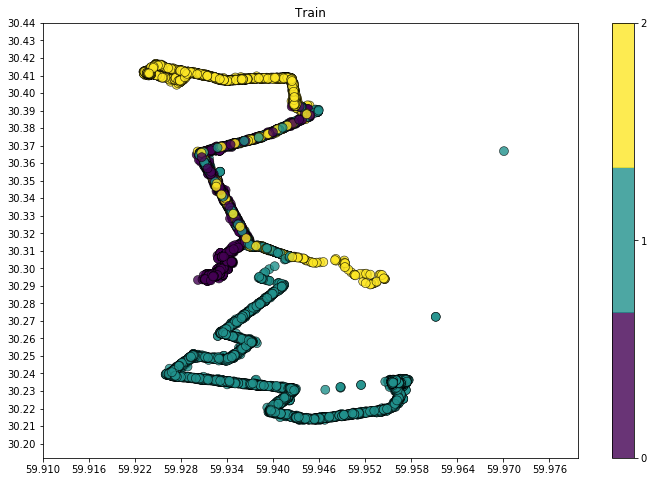

In [340]:
fig = plt.figure(figsize=(12, 8))

cmap = plt.get_cmap('viridis', 3)
plt.scatter(train_data['lat'], train_data['log'], c=y_train, edgecolors='black', linewidth=0.6, alpha=0.8, s=80, 
            cmap=cmap)
plt.colorbar(ticks=[0, 1, 2])
plt.title('Train')
plt.yticks(np.arange(30.2, 30.45, 0.01))
plt.xticks(np.arange(59.91, 59.98, 0.006));

In [383]:
 data.loc[data.query('lat >= 59.942383 & log <= 30.32 & log >= 30.29 & label == "-"').index, 'label'] = '2'

In [384]:
train_data, y_train, test_data = get_train_test_df(data)
train_data.head()

,log,lat,request_ts,trans_ts,request_time,trans_time,x,y,z
0,30.295780,59.932167,1511956827,1511956594,2017-11-29 15:00:27,2017-11-29 14:56:34,-0.422869,0.873954,-0.239554
1,30.219528,59.954617,1511956827,1511956746,2017-11-29 15:00:27,2017-11-29 14:59:06,-0.353008,0.898395,-0.261288
2,30.409101,59.931679,1511956827,1511956747,2017-11-29 15:00:27,2017-11-29 14:59:07,-0.519045,0.820630,-0.239080
3,30.385973,59.944260,1511956827,1511956782,2017-11-29 15:00:27,2017-11-29 14:59:42,-0.498340,0.829770,-0.251277
4,30.236233,59.955753,1511956827,1511956783,2017-11-29 15:00:27,2017-11-29 14:59:43,-0.367852,0.892098,-0.262385


In [385]:
train_data.shape, y_train.shape, test_data.shape

((33774, 9), (33774,), (5000, 9))

In [386]:
pd.value_counts(y_train)

1    15816
0     9273
2     8685
dtype: int64

In [387]:
%%time
for algo in algorithms:
    print(algo.__class__, get_mean_cv_acc(algo, train_data[['log', 'lat']], y_train))

<class 'sklearn.ensemble.forest.RandomForestClassifier'> 0.8541485308535044
<class 'sklearn.linear_model.logistic.LogisticRegression'> 0.6042511083795441
<class 'xgboost.sklearn.XGBClassifier'> 0.8735409576926283
<class 'sklearn.neighbors.classification.KNeighborsClassifier'> 0.8722977146535907
<class 'sklearn.svm.classes.SVC'> 0.7662395418245496
CPU times: user 4min 36s, sys: 2.97 s, total: 4min 39s
Wall time: 4min 41s


In [396]:
%%time
xgb_clf.fit(train_data[['log', 'lat']], y_train)

CPU times: user 2.45 s, sys: 6.74 ms, total: 2.46 s
Wall time: 2.48 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=17,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [400]:
y_pred = xgb_clf.predict(test_data[['log', 'lat']])
with open(os.path.join('data', 'transport_subm1.csv'), 'w') as f:
    f.write('\n'.join([str(y) for y in y_pred]))